Author:  Raphael Cousin

Project: https://github.com/racousin/algorithms_basics_python

# Theory

__Context:__

* Data : $X \in \mathbb{R}^d$ 


* Classes : $Y \in \{-1,1\}$

* Classifier :
$g^*(x) = \left\{\begin{array}{ll}1 & if\quad\mathbb{P}(Y = 1 | X = x) >\mathbb{P}(Y = -1 | X = x) \\-1 & else\end{array}\right.$

* sample size: $n$

* feature size : $p$

__Hypothesis:__

* $X|Y=1\sim \mathcal{N}(\mu_+, \Sigma_+)$

* $X|Y=-1\sim \mathcal{N}(\mu_-, \Sigma_-)$

__Maximum log likelihood:__

$Argmax\left\{\log(\mathbb{P}(X,Y|\Sigma,\mu,\pi)) = \\ \sum_{Y_j = 1} log(\pi_+) + \frac{1}{2}log(|\Sigma_+|) - \frac{1}{2} (x-\mu_+)^T\Sigma_+^{1}(x-\mu_+)+ \\ \sum_{Y_j = -1} log(\pi_-) + \frac{1}{2} log(|\Sigma_-|) - \frac{1}{2} (x-\mu_-)^T\Sigma_-^{1}(x-\mu_-)\right\}$

__Results:__


$g^*(x) = \left\{\begin{array}{ll}1 & if \quad h(x)+b>0\\-1 & else\end{array}\right.$

with:

$h(x) = \frac{1}{2}x^T(\Sigma^{-1}_- -\Sigma^{-1}_+)x + (\mu_+^T\Sigma^{-1}_+ - \mu_-^T\Sigma^{-1}_-)x$

$b =\frac{1}{2}(\mu_+ \Sigma^{-1}_+\mu_+ -\mu_- \Sigma^{-1}_-\mu_-) - \frac{1}{2} log(\frac{|\Sigma_+|}{|\Sigma_-|})+  log(\frac{\pi_+}{\pi_-})$

$\pi_i = \mathbb{P}(Y=i)$

__Maximum likelihood estimator:__

$\hat{\pi_i} = \frac{1}{n}\#[Y = i]$

$\hat{\mu_i} = \frac{1}{\#[Y = i]}\sum_{Y_j=i}X_j$

$\hat{\Sigma_i} = \frac{1}{\#[Y = i]}\sum_{Y_j=i}(X_j-\hat{\mu_i})(X_j-\hat{\mu_i})^T$ 

# Algorithm

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.discriminant_analysis import LinearClassifierMixin

In [366]:
class QDA(BaseEstimator, LinearClassifierMixin):
    """
        QDA classifier for two classes (-1,1)
    """
    def __init__(self):
        self.coef_linear = None
        self.coef_quadratic = None
        self.intercept = None
        
    def fit(self, X, y):
        #X data numpy array size (n,p)
        #Y class numpy array size (n,)
        X1 = X[y==1]
        X2 = X[y==-1]
        cov1 = np.cov(X1.T, bias=True)
        cov2 = np.cov(X2.T, bias=True)
        invcov1 = np.linalg.inv(cov1)
        invcov2 = np.linalg.inv(cov2)
        mu1 = X1.mean(axis=0)
        mu2 = X2.mean(axis=0)
        pi1, pi2 = len(X1), len(X2)
        X1, X2 = None, None
        self.coef_linear = mu1.dot(invcov1) - mu2.dot(invcov2)
        self.coef_quadratic = 0.5 * (invcov2 - invcov1)
        self.intercept = 0.5*(mu2.dot(invcov2.dot(mu2)) - mu1.dot(invcov1.dot(mu1))) + np.log(pi1/pi2) - 0.5 * np.log(np.linalg.det(cov1)/np.linalg.det(cov2))
        return self

    def decision_function(self, X):
        return (X.dot(qda.coef_quadratic)*X).sum(axis=1) + X.dot(self.coef_linear) + self.intercept

    def predict(self, X):
        return np.sign(self.decision_function(X))

# Example

In [278]:
#2d plot function
def plot_2dX_Y(X, Y, ax=plt):
    X1 = X[Y == 1]
    X2 = X[Y == -1]
    ax.plot(X1[:, 0], X1[:, 1], ">", label="Class 1")
    ax.plot(X2[:, 0], X2[:, 1], "d", label="Class 2")

In [331]:
# plot border from clf
def plot_border(clf, data=None, num=500, label=None,ax=plt):
    """
        Plot the frontiere f(x)=0 of the classifier clf within the same range as the one
        of the data.
        Input:
            clf: binary classifier with a method decision_function
            data: input data (X)
            num: discretization parameter
    """
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, num), np.linspace(ymin, ymax))
    z = np.fabs(clf.decision_function(np.c_[x.ravel(), y.ravel()])).reshape(x.shape)
    zmin, zmax = z.min(), z.max()
    ind = np.where((z-zmin)/(zmax-zmin) < 0.0001)
    ind_sort = np.argsort(y[ind])
    ax.plot(x[ind][ind_sort], y[ind][ind_sort], label=label, linewidth=2)

In [355]:
def get_metrics(clf,X,Y):
    """
        Input:
            clf: binary classifier with a method predict_function
            data: (X)
            classes: (Y) consider that Y=1 is 'yes class' and Y=-1 is 'No class'
    """
    pred = clf.predict(X)
    TP = ((pred == 1) & (Y == 1)).sum()
    TN = ((pred == -1) & (Y == -1)).sum()
    FP = ((pred == 1) & (Y == -1)).sum()
    FN = ((pred == -1) & (Y == 1)).sum()
    accuracy = (TP + TN) / (TP + TN + FN + FP)
    prec = TP/ (TP + FP)
    recall = TP / (TP + FN)
    F1Score = 2*(recall * prec) / (recall + prec)
    print('True Positive:',TP)
    print('True Negative:',TN)
    print('False Positive:',FP)
    print('False Negative:',FN)
    print('Accuracy:', accuracy)
    print('Precision:', prec)
    print('Recall:', recall)
    print('F1 Score:', F1Score)

In [350]:
#generate data
p = 2;
n = 1000;
mu1 = np.random.randn(p) +3
mu2 = np.random.randn(p) -2
A = np.random.rand(p,p)
sigma1 = np.dot(A,A.transpose())
A = np.random.rand(p,p)
sigma2 = np.dot(A,A.transpose())

n1 = np.random.randint(int(n*0.1),int(n*0.9));
n2 = n - n1;
X1 = np.random.multivariate_normal(size=n1,mean=mu1,cov=sigma1)
X2 = np.random.multivariate_normal(size=n2,mean=mu2,cov=sigma2)

Y1 = np.ones(n1)
Y2 = -np.ones(n2)
X = np.r_[X1, X2]
Y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0])]

In [351]:
#train set and test set
data = np.c_[X,Y]
np.random.shuffle(data)
X_train = data[:int(n *0.9),0:p]
Y_train = data[:int(n *0.9),p]
X_test = data[int(n *0.9):,0:p]
Y_test = data[int(n *0.9):,p]

In [367]:
#compute model
qda = QDA()
qda.fit(X_train, Y_train)

QDA(prior=True)

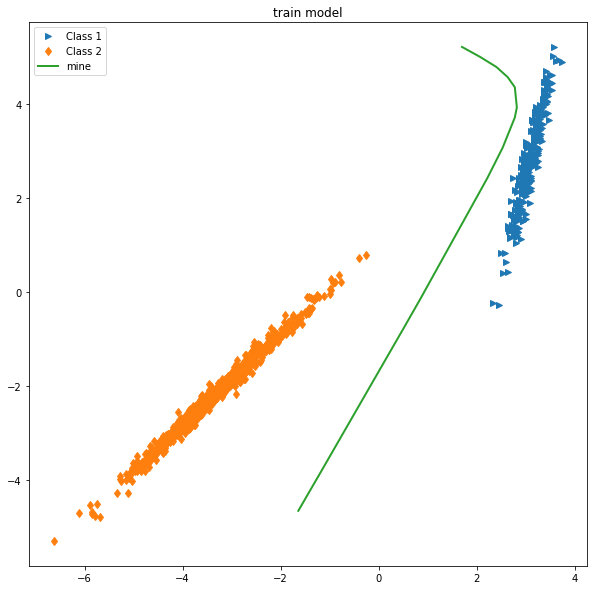

In [368]:
#plot train
fig, ax = plt.subplots(figsize=(10,10))
plot_2dX_Y(X_train, Y_train,ax)
plot_border(qda, X_train,ax = ax,label='mine')
ax.set_title('train model')
ax.legend(loc="best");

In [369]:
#metrics train
get_metrics(qda, X_train, Y_train)

True Positive: 260
True Negative: 640
False Positive: 0
False Negative: 0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [365]:
Y_train == 1

array([False, False, False, False,  True, False, False,  True, False,
       False, False,  True,  True, False, False, False, False,  True,
       False, False, False,  True, False,  True, False,  True,  True,
       False, False,  True,  True, False,  True, False, False, False,
       False, False, False, False,  True, False, False,  True,  True,
       False, False,  True, False, False, False, False, False, False,
        True, False, False, False,  True, False,  True, False, False,
       False, False,  True,  True,  True, False,  True, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False,  True,  True, False, False,  True,
        True, False,  True,  True,  True, False, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False,  True,
        True, False,

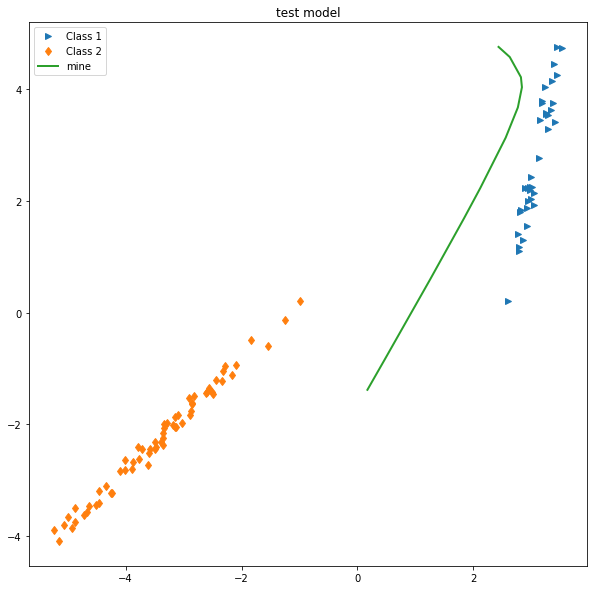

In [370]:
#plot test
fig, ax = plt.subplots(figsize=(10,10))
plot_2dX_Y(X_test, Y_test,ax)
plot_border(qda, X_test,ax = ax,label='mine')
ax.set_title('test model')
ax.legend(loc="best");

In [373]:
#metrics test
get_metrics(qda, X_test, Y_test)

True Positive: 36
True Negative: 64
False Positive: 0
False Negative: 0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


# References

In [374]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis